# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
k = np.array([0.8, 0.2])
entropy = np.round(-np.sum(k*np.log(k)), 2)
entropy

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
k = np.array([0.8, 0.2])
k_1 = 8
k_2 = 2
K = 10
k_l = np.array([1, 0])
k_r = np.array([0, 1])

Q = np.round((np.sum(k*(1 - k))) - (k_1/K)*(np.sum(k_l*(1 - k_l))) - (k_2/K)*(np.sum(k_r*(1 - k_r))), 2)
Q


0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
targets = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
R = 10
Y_R = (1/R)*np.sum(targets)
Y_R

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева +
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число) +
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
    
    f_v = np.array(sorted(np.unique(feature_vector)))
              
    def gini(sht):
        count_classes = np.unique(sht, return_counts = True)[1]
        ps = count_classes/np.sum(count_classes)
        znach = np.sum(ps*(1 - ps))
        return znach
    
    def counting_impurity(shtuka, target_vector, H_R):
        y_right = target_vector[np.array(shtuka != 0)]
        y_left = target_vector[np.array(shtuka == 0)]
        impurity = H_R(target_vector) - (len(y_left)/len(target_vector))*H_R(y_left) - (len(y_right)/len(target_vector))*H_R(y_right)
        return impurity
    
    if feature_type == 'real':
        thresholds = (np.array(f_v[:-1]) + np.array(f_v[1:]))/2.0
        shtuka = feature_vector[np.newaxis, :] < thresholds[:, np.newaxis]
        
    elif feature_type == 'categorical':
        thresholds = f_v
        shtuka = feature_vector[np.newaxis, :] == thresholds[:, np.newaxis]
        
    if task == 'regression':
        H_R = np.var
    elif task == 'classification':
        H_R = gini
        
    ginis = np.apply_along_axis(counting_impurity, 1, shtuka, target_vector, H_R)
    threshold_best = thresholds[np.argmax(np.array(ginis))]
    gini_best = np.max(np.array(ginis))
    
    return (thresholds, ginis, threshold_best, gini_best)

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X['MedInc'], 
    y, 
    task="regression",
    feature_type="real"
)

/tmp/ipykernel_233/3760510600.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  shtuka = feature_vector[np.newaxis, :] < thresholds[:, np.newaxis]


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

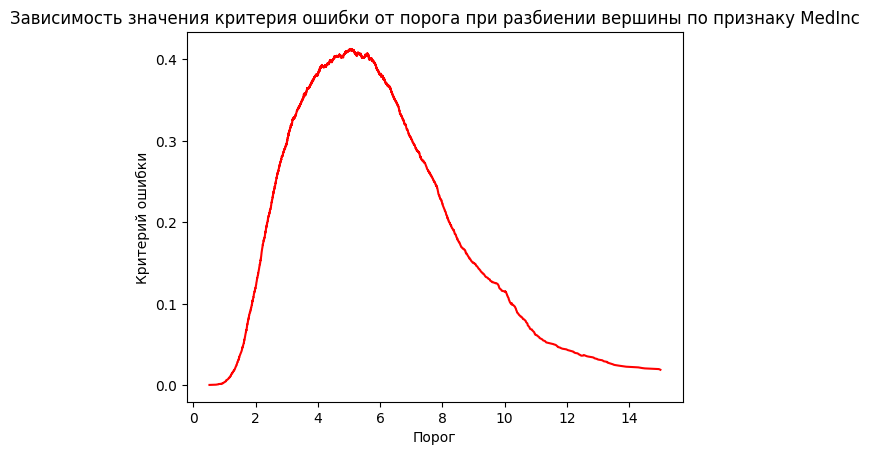

In [10]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
plt.plot(thresholds, variances, color = 'red')
plt.title('Зависимость значения критерия ошибки от порога при разбиении вершины по признаку MedInc')
plt.xlabel('Порог')
plt.ylabel('Критерий ошибки')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [11]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
gini_best = -100000
for col in X:
    thresholds, variances, threshold_best, variance_best = find_best_split(X[col], y, task = "regression")
    if variance_best > gini_best:
        gini_best = variance_best
        best_col = col
print(gini_best, best_col)      

/tmp/ipykernel_233/3760510600.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  shtuka = feature_vector[np.newaxis, :] < thresholds[:, np.newaxis]


0.41275138620167695 MedInc


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [12]:
from scipy import stats as st

In [13]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector != threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])
    
    # функция для заполнения пропущенных значений
    def fill_na(self, X: np.ndarray):
        # для вещественных признаков можно использовать медиану
        if np.any(self._feature_types == 'real'):
            column_median = np.nanmedian(X, axis=0)
            k = self._feature_types == 'real'
            condition = np.logical_and(np.tile(k, (X.shape[0], 1)), np.isnan(X)) #тут только logical_and подходит, "&" выдает не то       
            indices = np.where(condition)
            for i in range(len(indices[0])):
                X[indices[0][i]][indices[1][i]] = column_median[indices[1][i]] 
        # а для категориальных - моду
        if np.any(self._feature_types == 'categorical'):
            column_mode = st.mode(X, axis=0, nan_policy='omit')
            k = self._feature_types == 'categorical'
            condition = np.logical_and(np.tile(k, (X.shape[0], 1)), np.isnan(X)) #тут только logical_and подходит, "&" выдает не то       
            indices = np.where(condition)
            for i in range(len(indices[0])):
                X[indices[0][i]][indices[1][i]] = column_mode[indices[1][i]] 
            
        
    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node['type'] == 'terminal':
            return node['class']
        
        feature_index = node["feature_split"]
        feature_value = x[feature_index]
        feature_type = self._feature_types[feature_index]
        
        if feature_type == "real":        
            if feature_value < node["threshold"]:
                res = self._predict_node(x, node["left_child"])
            else:
                res = self._predict_node(x, node["right_child"])
        else:
            if feature_value == node["category_split"]:
                res = self._predict_node(x, node["right_child"])
            else:
            
                res = self._predict_node(x, node["left_child"])
        
        return res   
  

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        if np.isnan(X).any():
            X = self.fill_na(X)
        self._fit_node(X, y, self._tree)
        

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        if np.isnan(X).any():
            X = self.fill_na(X)
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [14]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
students_data = pd.read_csv('students.csv')
students_data

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...,...
253,253,0.61,0.78,0.69,0.92,0.58,1
254,254,0.78,0.61,0.71,0.19,0.60,1
255,255,0.54,0.82,0.71,0.29,0.77,1
256,256,0.50,0.75,0.81,0.61,0.26,1


In [15]:
features = list(students_data.columns[1:-1])
features

['STG', 'SCG', 'STR', 'LPR', 'PEG']

In [16]:
target_vector = students_data['UNS'].values

In [17]:
X = students_data[features]
X

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58
254,0.78,0.61,0.71,0.19,0.60
255,0.54,0.82,0.71,0.29,0.77
256,0.50,0.75,0.81,0.61,0.26


/tmp/ipykernel_233/3760510600.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  shtuka = feature_vector[np.newaxis, :] < thresholds[:, np.newaxis]


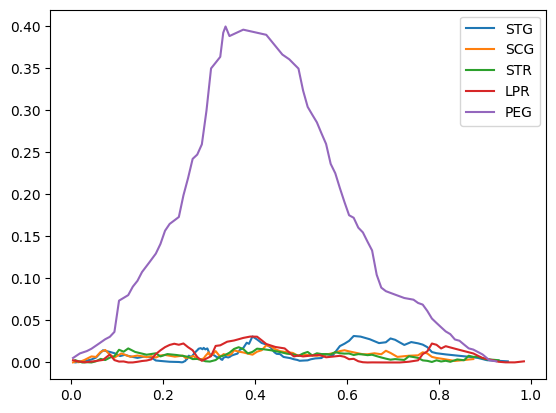

In [18]:
for col in X:
    thresholds, variances, threshold_best, variance_best = find_best_split(X[col], target_vector, task = "classification", feature_type = 'real')
    plt.plot(thresholds, variances, label = col)
plt.legend()

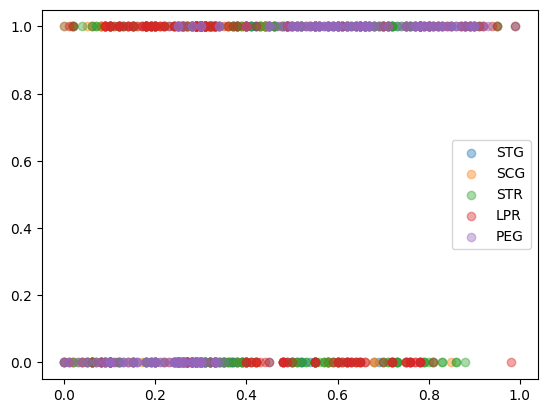

In [19]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
#Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.
for col in X:
    plt.scatter(X[col], target_vector, alpha = 0.4, label = col)
plt.legend()

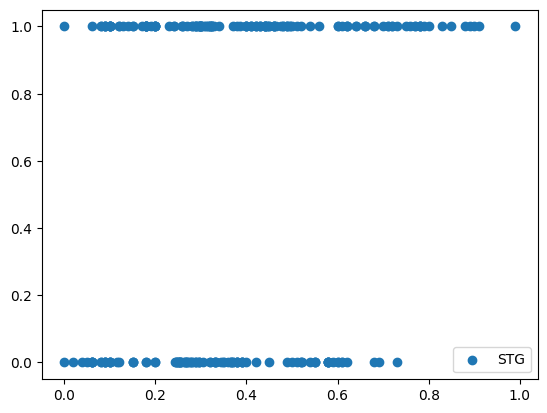

In [20]:
plt.scatter(X[features[0]], target_vector, label = features[0])
plt.legend()

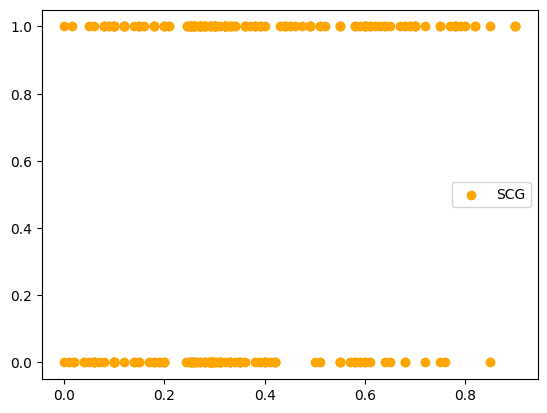

In [21]:
plt.scatter(X[features[1]], target_vector, color = 'orange', label = features[1])
plt.legend()

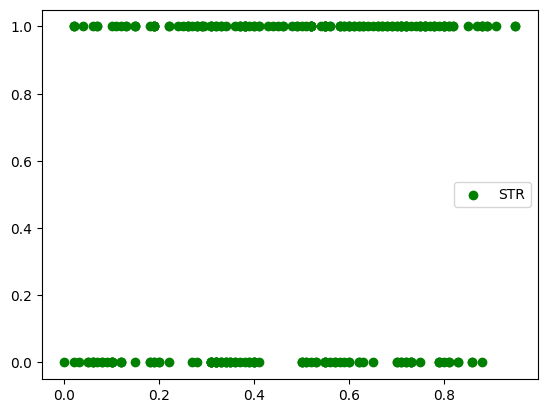

In [22]:
plt.scatter(X[features[2]], target_vector, color = 'green', label = features[2])
plt.legend()

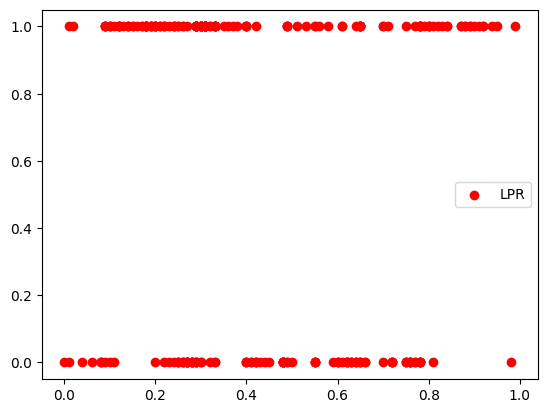

In [23]:
plt.scatter(X[features[3]], target_vector, color='red', label = features[3])
plt.legend()

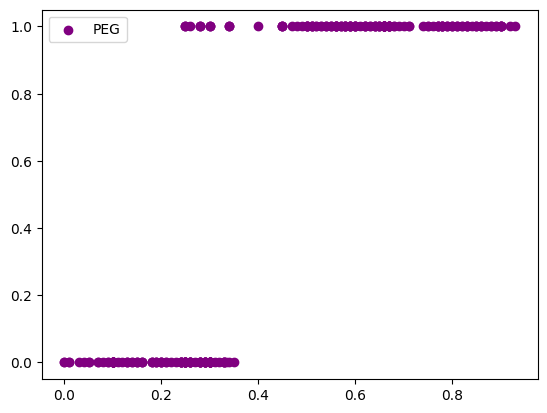

In [24]:
plt.scatter(X[features[4]], target_vector, color='purple', label = features[4])
plt.legend()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

#### Ответ:
По критерию Джини, разбивать выборку на два поддерева надо по признаку 'PEG', то же самое показывает и диаграмма рассеяния, так что результат с ней согласуется.
Вид кривой для "хороших" признаков должен быть похож на график нормального распределения с вершиной, наиболее удаленной от оси Х.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [25]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
df = pd.read_csv('agaricus-lepiota.data')

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [27]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for col in df:
    df[col] = le.fit_transform(df[col])

In [28]:
y = df['p']
X = df.drop('p', axis= 1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123, shuffle=True)

In [30]:
dt = DecisionTree(feature_types = (["categorical"]*(X_train.shape[1])), max_depth=8, min_samples_leaf=2,  min_samples_split=2, task = 'classification')

In [31]:
dt.fit(np.array(X_train), np.array(y_train))
y_pred_dt = dt.predict(np.array(X_test))
print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

Decision tree accuracy: 1.00


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [32]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [33]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

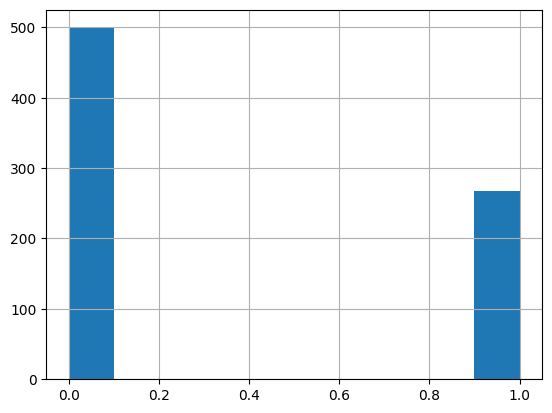

In [34]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [35]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
diabetes_Y = data['Outcome']
diabetes_X = data.drop('Outcome', axis= 1) 
X_train, X_test, y_train, y_test = train_test_split(diabetes_X, diabetes_Y, test_size=0.3, random_state=123, shuffle=True)
X_train_not_full, X_val, y_train_not_full, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=123, shuffle=True)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [36]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
max_depth = [2, 4, 8, 10, 15, 20]
min_samples_leaf = [2, 3, 5, 7, 8, 9, 20]
f1_score_best = 0
max_depth_best = 0
min_samples_leaf_best = 0
for i in max_depth:
    for j in min_samples_leaf:
        dt = DecisionTreeClassifier(max_depth=i, min_samples_leaf=j, random_state=13)
        dt.fit(X_train_not_full, y_train_not_full)
        y_pred_dt = dt.predict(X_val)
        if f1_score_best < f1_score(y_pred_dt, y_val):
            max_depth_best = i
            min_samples_leaf_best = j
            f1_score_best = f1_score(y_pred_dt, y_val)

dt = DecisionTreeClassifier(max_depth=max_depth_best, min_samples_leaf=min_samples_leaf_best, random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")
print(f"Decision tree precision: {precision_score(y_pred_dt, y_test):.2f}")
print(f"Decision tree recall: {recall_score(y_pred_dt, y_test):.2f}")
print(f"Decision tree auc_roc: {roc_auc_score(y_pred_dt, y_test):.2f}")

Decision tree accuracy: 0.75
Decision tree precision: 0.41
Decision tree recall: 0.88
Decision tree auc_roc: 0.80


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [37]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

bag = BaggingClassifier(n_estimators=50)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
print(f"Bagging accuracy: {accuracy_score(y_pred_bag, y_test):.2f}")
print(f"Bagging precision: {precision_score(y_pred_bag, y_test):.2f}")
print(f"Bagging recall: {recall_score(y_pred_bag, y_test):.2f}")
print(f"Bagging auc_roc: {roc_auc_score(y_pred_bag, y_test):.2f}")

Bagging accuracy: 0.78
Bagging precision: 0.68
Bagging recall: 0.72
Bagging auc_roc: 0.77


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [38]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import cross_validate
max_depth = [2, 4, 6, 8, 10]
min_samples_split = [2, 5, 7, 9]
criterion = 0
max_depth_best = 0
min_samples_split_best = 0
for i in max_depth:
    for j in min_samples_split:
        estimator = RandomForestClassifier(n_estimators=50, max_depth=i, min_samples_split=j, random_state=123)
        sht = cross_validate(estimator, X_train, y_train, scoring='f1', cv=5)['test_score'].mean()
        if criterion < sht:
            criterion = sht
            max_depth_best = i
            min_samples_split_best = j
print(max_depth_best, min_samples_split_best)


8 2


In [39]:
rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth_best, min_samples_split=min_samples_split_best, random_state=123)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Random Forest precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Random Forest recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"Random Forest auc_roc: {roc_auc_score(y_test, y_pred_rf):.2f}")

Random Forest accuracy: 0.79
Random Forest precision: 0.76
Random Forest recall: 0.66
Random Forest auc_roc: 0.77


Из трех построенных моделей лучше всего себя показал Random Forest, на мой взгляд, потому что у него все у него все метрики показывают примерно близкие значения, довольно высокая точность (самая высокая из всех трех моделей) и auc_roc. Но если не смотреть на точность, высокие показатели и у Decision Tree: самая высокая полнота и самое высокое значение auc_roc.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [42]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
n_estimators_li = list(range(1, 1001))
scores = []

for i in n_estimators_li:
    model = RandomForestClassifier(random_state=0, max_depth=max_depth_best, min_samples_leaf=min_samples_leaf_best, n_estimators = i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))

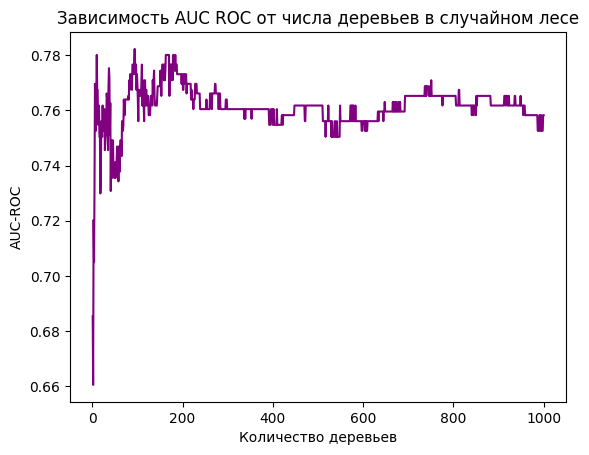

In [43]:
x = n_estimators_li
y = scores

plt.title('Зависимость AUC ROC от числа деревьев в случайном лесе')
plt.xlabel('Количество деревьев')
plt.ylabel('AUC-ROC')
plt.plot(x, y, color = 'purple')
plt.show()

По графику зависимости AUC ROC на тестовой выборке от числа деревьев (n_estimators) для случайного леса, обучаемого на полной обучающей выборке, можно сделать вывод, что, при наличии ограничений на максимальную глубину и min_samples_leaf, чем больше деревьев, тем более стабильным оказывается значение AUC ROC, как видно, колебания становятся меньще ближе к правому краю графика, однако самые высокие значения достигаются до количества деревьев = 200.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [44]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
model = RandomForestClassifier(random_state=0, max_depth=max_depth_best, min_samples_leaf=min_samples_leaf_best, n_estimators = 50)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=2, n_estimators=50,
                       random_state=0)

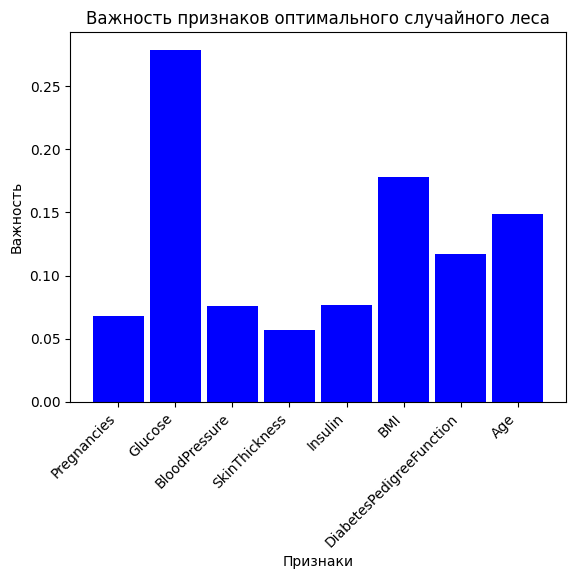

In [45]:
features = list(data.columns[:-1])
coefs = model.feature_importances_
plt.bar(features, coefs, width = 0.9, color = 'blue')
plt.title('Важность признаков оптимального случайного леса')
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.show()

Самым важным оказался признак 'Glucose', то есть количество глюкозы. 